In [4]:
#from IPython.display import display, HTML
#display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

from astropy.table import Table
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np 
import scipy.integrate as integrate
import os
import scipy.stats as spstat
from collections import OrderedDict
%matplotlib inline

In [5]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="media/SN98bu_LC.mp4" type="video/mp4">
</video>
</div>

In [6]:
obj1 = Table.read('data/fake010.csv', format='csv')
obj1

object_id,mjd,passband,flux,flux_err,detected_bool
int64,float64,int64,float64,float64,int64
10,56210.172,1,5.659,3.7,1
10,56210.188,2,21.32,3.245,1
10,56210.203,3,13.28,3.221,1
10,56210.234,4,9.579,3.85,1
10,56218.172,1,49.22,1.654,1
10,56218.191,2,114.6,2.376,1
10,56218.211,3,88.85,2.261,1
10,56219.156,4,75.01,2.394,1
10,56221.273,1,62.28,4.17,1


In [7]:
obj2 = Table.read('data/fake030.csv', format = 'csv')
obj2

object_id,mjd,passband,flux,flux_err,detected_bool
int64,float64,int64,float64,float64,int64
30,56423.665618,0,272.897778,3.770222,1
30,56423.814222,0,448.33227,4.542222,1
30,56423.895484,0,311.60183,3.156955,1
30,56424.718744,0,370.851466,4.098802,1
30,56424.810501,0,277.459756,3.577698,1
30,56424.888096,0,286.813771,3.698313,1
30,56450.6106,0,666.1929,6.135863,1
30,56450.729981,0,334.19504,3.385855,1
30,56450.83466,0,285.759054,3.158326,1


In [8]:
data = pd.read_csv('data/fake010.csv')
data.head()
mjd = data['mjd'].values
flux = data['flux'].values

plt.scatter(mjd, flux)

integral_trapz = np.trapz(flux,mjd)

print("Integral using trapezoidal rule:", integral_trapz)

Integral using trapezoidal rule: 6016.562920500986


In [9]:
class LightCurve(object):
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, filename):
        self.DFlc     = Table.read(filename, format='ascii.csv')
        self.filename = filename.replace('.csv','')
        self._finalize()

    def _finalize(self):
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = spstat.skew(f) 
            
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    def plot_multicolor_lc(self, phase=None):
        fig, ax = plt.subplots(figsize=(8,6))
        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol = 4, frameon = True)
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        fig.suptitle(self.filename, fontsize='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats

In [10]:
lc2 = LightCurve('data/fake010.csv')
type(lc2.DFlc)
foo2 = lc2.DFlc.to_pandas()

In [11]:
bar2 = foo2[foo2['passband']==4]

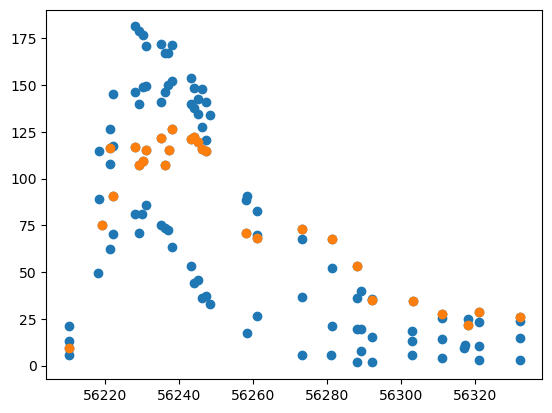

In [12]:
plt.scatter(bar2.mjd,bar2.flux)
plt.show()

C:\Users\tyler\AppData\Local\Temp\ipykernel_24880\2194405512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar2['cumulative_flux'] = bar2['flux'].cumsum()


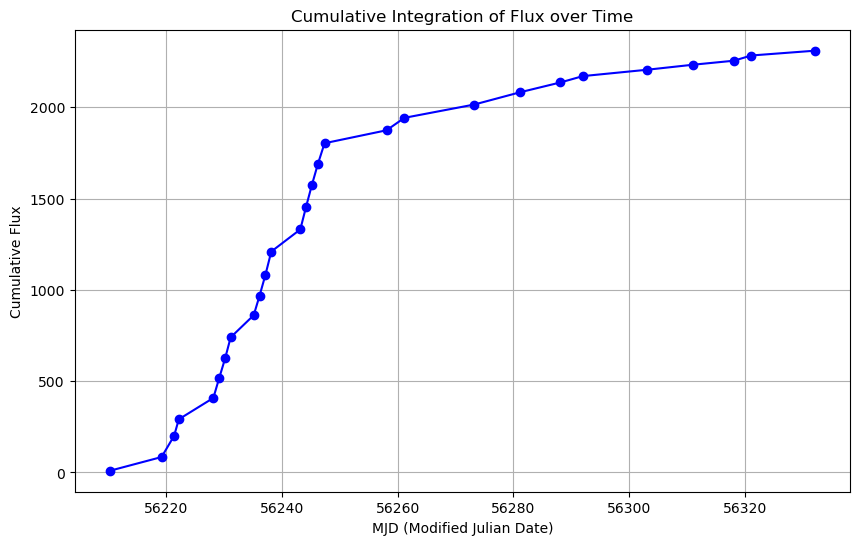

In [13]:
data = pd.read_csv('data/fake010.csv')

data = data.sort_values(by='mjd')

bar2['cumulative_flux'] = bar2['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(bar2['mjd'], bar2['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time')
plt.grid()
plt.show()

In [14]:
lc = LightCurve('data/fake030.csv')
type(lc.DFlc)
foo = lc.DFlc.to_pandas()

In [15]:
bar = foo[foo['passband']==4]

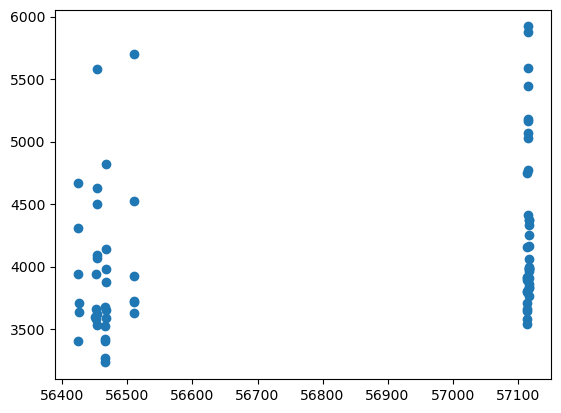

In [16]:
plt.scatter(bar.mjd,bar.flux)
plt.show()

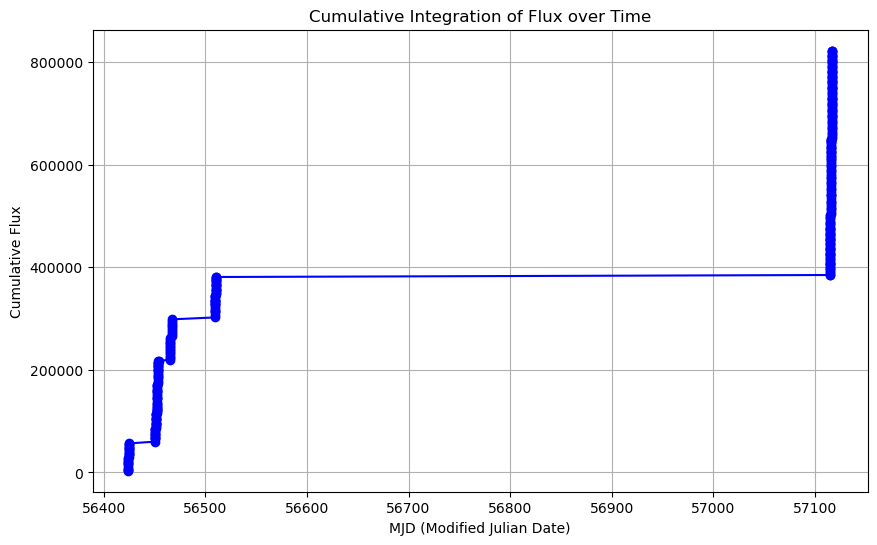

In [17]:
data = pd.read_csv('data/fake030.csv')

data = data.sort_values(by='mjd')

data['cumulative_flux'] = data['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data['mjd'], data['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time')
plt.grid()
plt.show()

In [18]:
data = np.load("plasticc-kit/data/plasticc_featuretable.npz",allow_pickle=True)

In [19]:
data.files

['features']

In [20]:
pd.set_option('display.max_rows', 100)
data2 = pd.read_csv("plasticc_train_lightcurves.csv.gz")


In [21]:
data2

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [22]:
value = input('object_id')

try:
    object_id = int(value)
    if object_id in data2['object_id'].values:
        print(data2[data2['object_id'] == object_id])
    else:
        print(f"object_id {object_id} not found.")
except ValueError:
    print("Not an object_id.")

object_id 4173


      object_id         mjd  passband      flux  flux_err  detected_bool
8356       4173  59582.3282         0 -3.190367  2.772365              0
8357       4173  59583.2409         0 -1.194870  2.448951              0
8358       4173  59584.2432         0 -1.202452  2.474045              0
8359       4173  59585.2363         0  5.319989  2.845091              0
8360       4173  59586.2371         0 -0.714653  3.248791              0
...         ...         ...       ...       ...       ...            ...
8606       4173  60434.0005         3  0.218266  1.290947              0
8607       4173  60434.0115         4 -2.260434  1.973108              0
8608       4173  60434.0224         5 -5.203778  4.920425              0
8609       4173  60435.9857         0 -2.403626  2.542131              0
8610       4173  60436.9840         0  1.726425  2.923982              0

[255 rows x 6 columns]


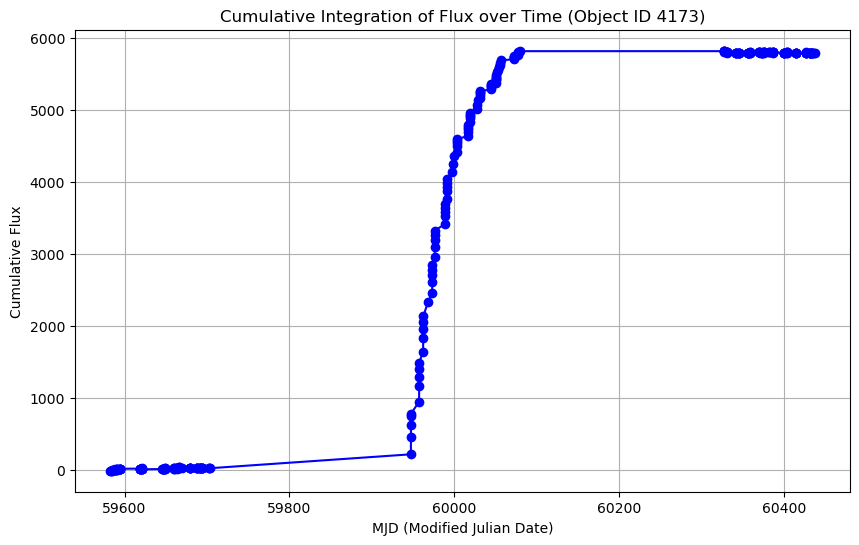

In [23]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")

data_4173 = data[data['object_id'] == 4173]

data_4173 = data_4173.sort_values(by='mjd')

data_4173['cumulative_flux'] = data_4173['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_4173['mjd'], data_4173['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 4173)')
plt.grid()
plt.show()

Max smoothed slope: 16223.9441


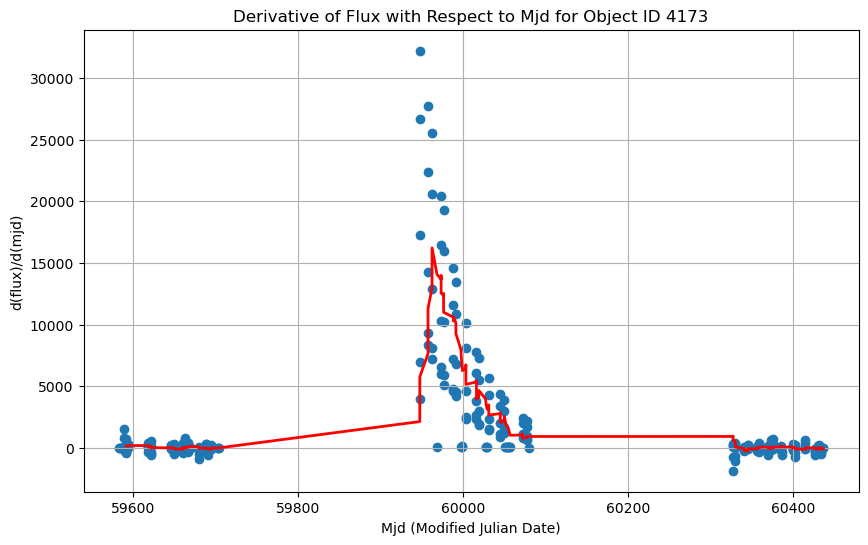

In [83]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_4173 = data[data['object_id'] == 4173]
data_4173 = data_4173.sort_values(by='mjd')

data_4173['cumulative_flux'] = data_4173['flux'].cumsum()
data_4173['flux_derivative'] = np.gradient(data_4173['cumulative_flux'], data_4173['mjd'])

data_4173.set_index('mjd', inplace=True)

smoothing = data_4173['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_4173.index, data_4173['flux_derivative'])
plt.plot(data_4173.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 4173')
plt.grid()
plt.show()


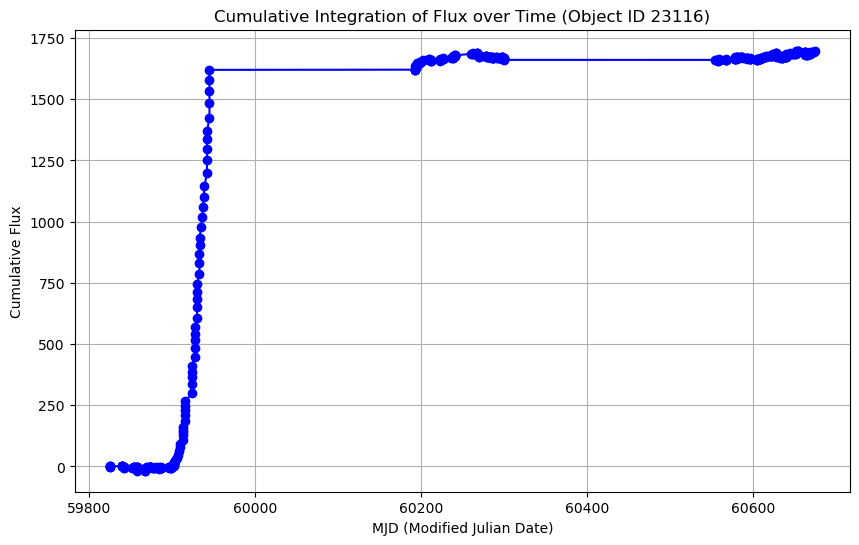

In [25]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_23116 = data[data['object_id'] == 23116]
data_23116 = data_23116.sort_values(by='mjd')

data_23116['cumulative_flux'] = data_23116['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_23116['mjd'], data_23116['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 23116)')
plt.grid()
plt.show()

Max smoothed slope: 3737.8600


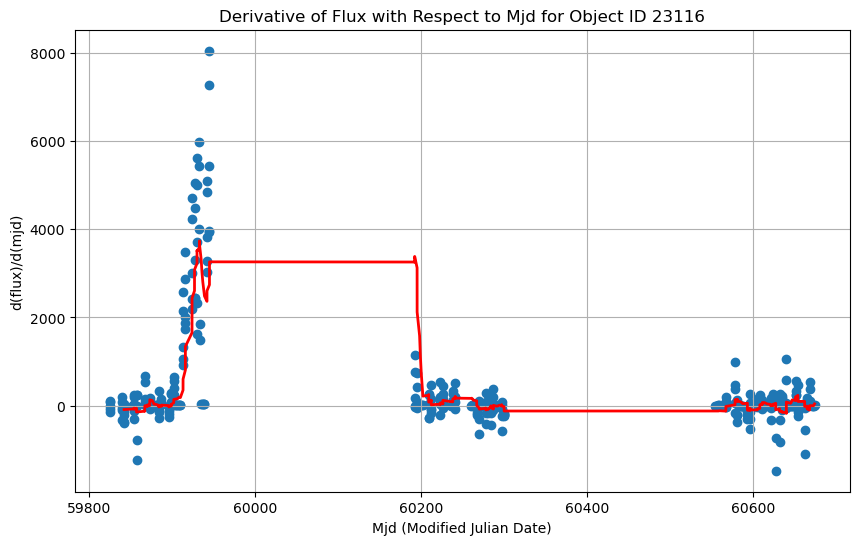

In [85]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_23116 = data[data['object_id'] == 23116]
data_23116 = data_23116.sort_values(by='mjd')

data_23116['cumulative_flux'] = data_23116['flux'].cumsum()
data_23116['flux_derivative'] = np.gradient(data_23116['cumulative_flux'], data_23116['mjd'])

data_23116.set_index('mjd', inplace=True)

smoothing = data_23116['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_23116.index, data_23116['flux_derivative'], label='Derivative of Flux for object_id 23116')
plt.plot(data_23116.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 23116')
plt.grid()
plt.show()


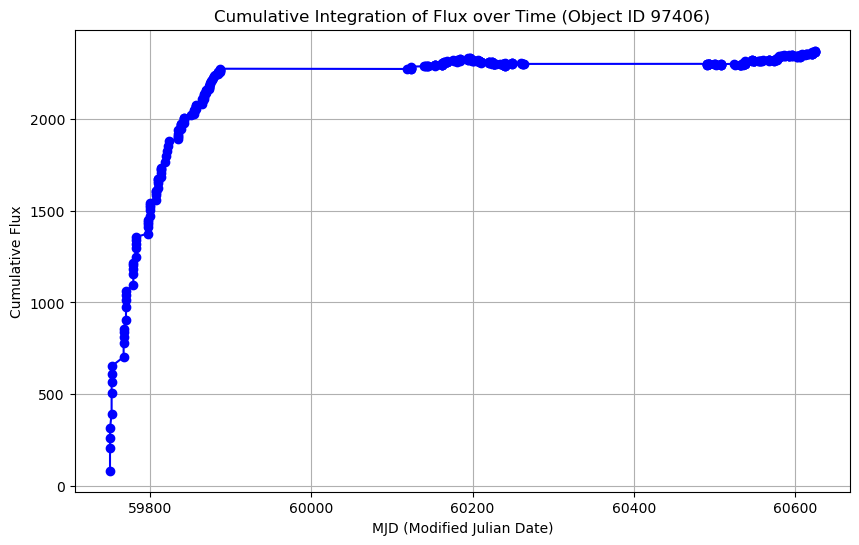

In [27]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_97406 = data[data['object_id'] == 97406]
data_97406 = data_97406.sort_values(by='mjd')

data_97406['cumulative_flux'] = data_97406['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_97406['mjd'], data_97406['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 97406)')
plt.grid()
plt.show()

Max smoothed slope: 7743.6548


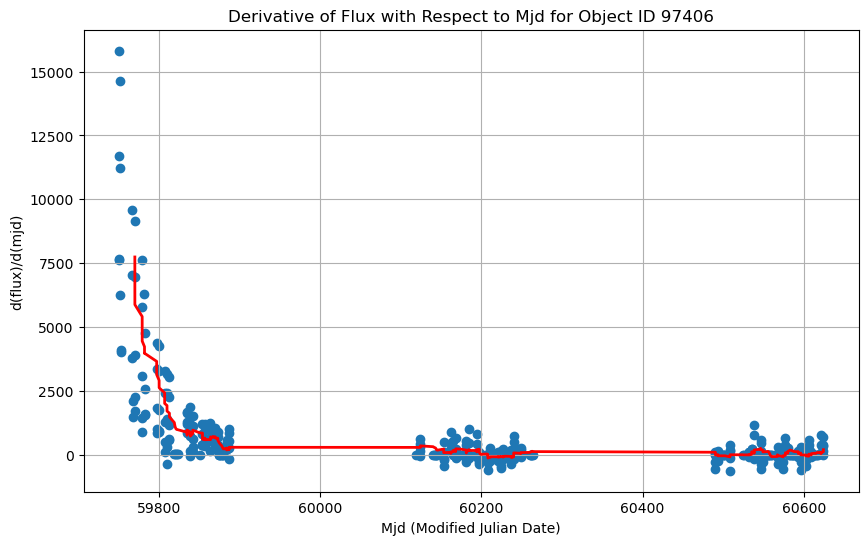

In [87]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_97406 = data[data['object_id'] == 97406]
data_97406 = data_97406.sort_values(by='mjd')

data_97406['cumulative_flux'] = data_97406['flux'].cumsum()
data_97406['flux_derivative'] = np.gradient(data_97406['cumulative_flux'], data_97406['mjd'])

data_97406.set_index('mjd', inplace=True)

smoothing = data_97406['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_97406.index, data_97406['flux_derivative'], label='Derivative of Flux for object_id 97406')
plt.plot(data_97406.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 97406')
plt.grid()
plt.show()

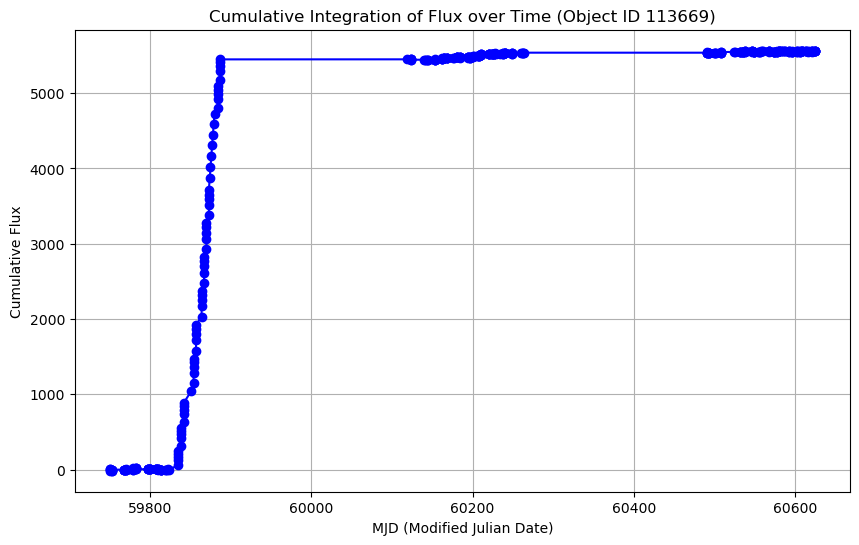

In [29]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_113669 = data[data['object_id'] == 113669]
data_113669 = data_113669.sort_values(by='mjd')

data_113669['cumulative_flux'] = data_113669['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_113669['mjd'], data_113669['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 113669)')
plt.grid()
plt.show()

Max smoothed slope: 10312.0509


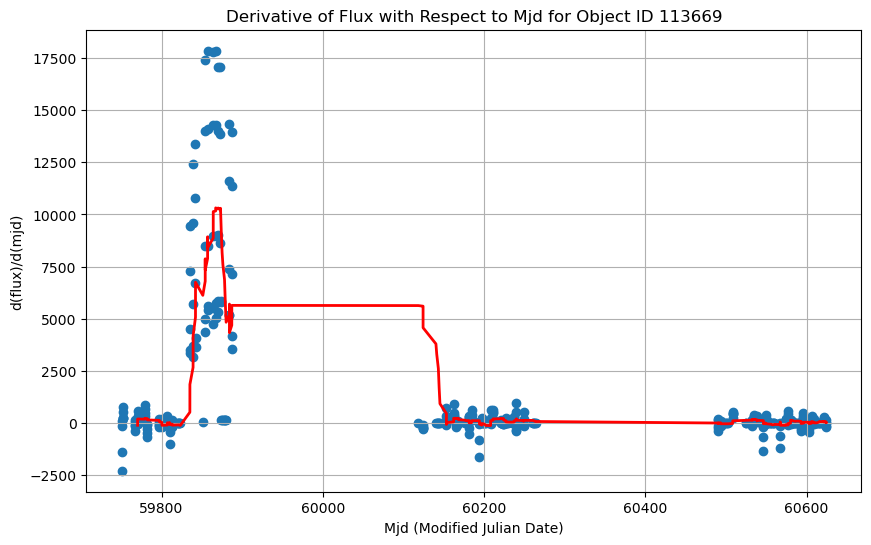

In [89]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_113669 = data[data['object_id'] == 113669]
data_113669 = data_113669.sort_values(by='mjd')

data_113669['cumulative_flux'] = data_113669['flux'].cumsum()
data_113669['flux_derivative'] = np.gradient(data_113669['cumulative_flux'], data_113669['mjd'])

data_113669.set_index('mjd', inplace=True)

smoothing = data_113669['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_113669.index, data_113669['flux_derivative'], label='Derivative of Flux for object_id 113669')
plt.plot(data_113669.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 113669')
plt.grid()
plt.show()

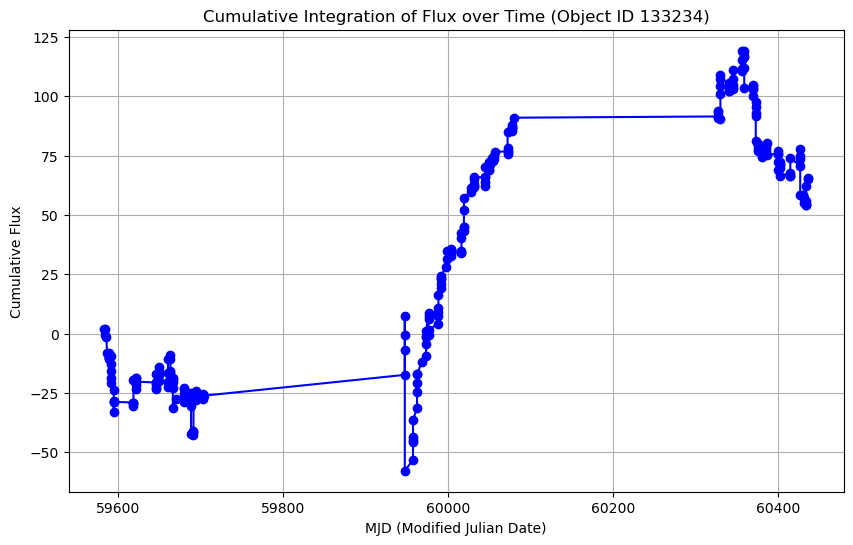

In [31]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_133234 = data[data['object_id'] == 133234]
data_133234 = data_133234.sort_values(by='mjd')

data_133234['cumulative_flux'] = data_133234['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_133234['mjd'], data_133234['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 133234)')
plt.grid()
plt.show()

Max smoothed slope: 430.9596


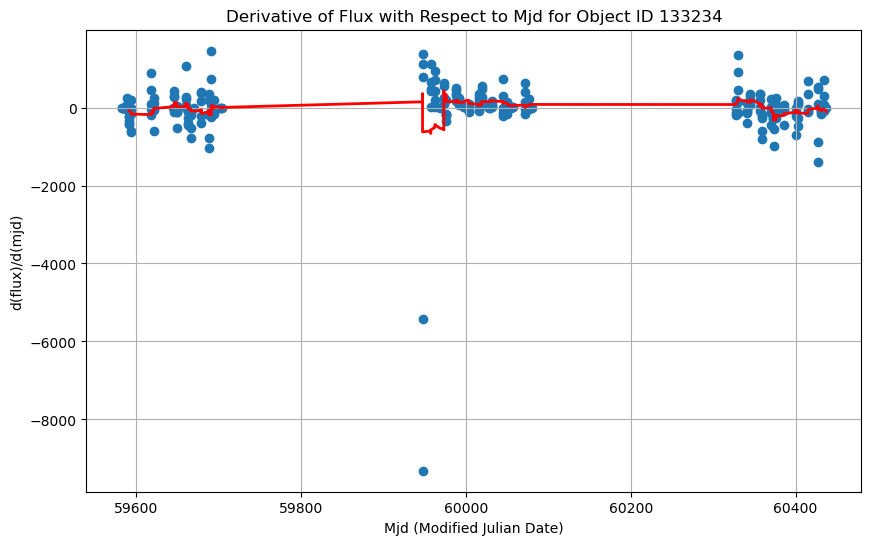

In [91]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_133234 = data[data['object_id'] == 133234]
data_133234 = data_133234.sort_values(by='mjd')

data_133234['cumulative_flux'] = data_133234['flux'].cumsum()
data_133234['flux_derivative'] = np.gradient(data_133234['cumulative_flux'], data_133234['mjd'])

data_133234.set_index('mjd', inplace=True)

smoothing = data_133234['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_133234.index, data_133234['flux_derivative'], label='Derivative of Flux for object_id 133234')
plt.plot(data_133234.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 133234')
plt.grid()
plt.show()

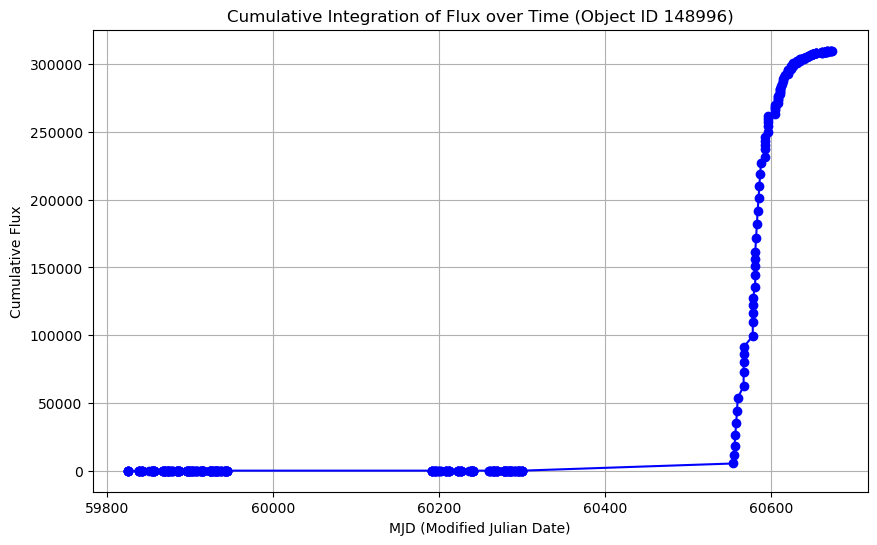

In [33]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_148996 = data[data['object_id'] == 148996]
data_148996 = data_148996.sort_values(by='mjd')

data_148996['cumulative_flux'] = data_148996['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_148996['mjd'], data_148996['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 148996)')
plt.grid()
plt.show()

Max smoothed slope: 819628.3952


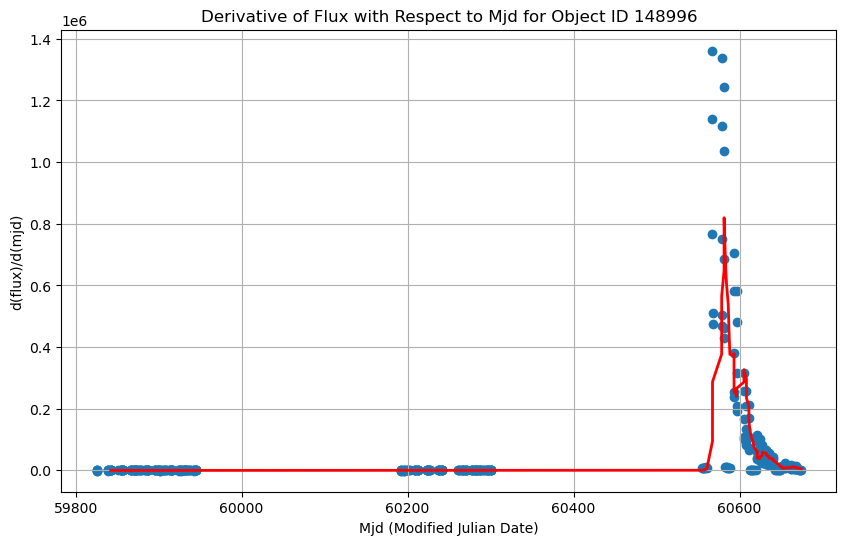

In [93]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_148996 = data[data['object_id'] == 148996]
data_148996 = data_148996.sort_values(by='mjd')

data_148996['cumulative_flux'] = data_148996['flux'].cumsum()
data_148996['flux_derivative'] = np.gradient(data_148996['cumulative_flux'], data_148996['mjd'])

data_148996.set_index('mjd', inplace=True)

smoothing = data_148996['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_148996.index, data_148996['flux_derivative'], label='Derivative of Flux for object_id 148996')
plt.plot(data_148996.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 148996')
plt.grid()
plt.show()

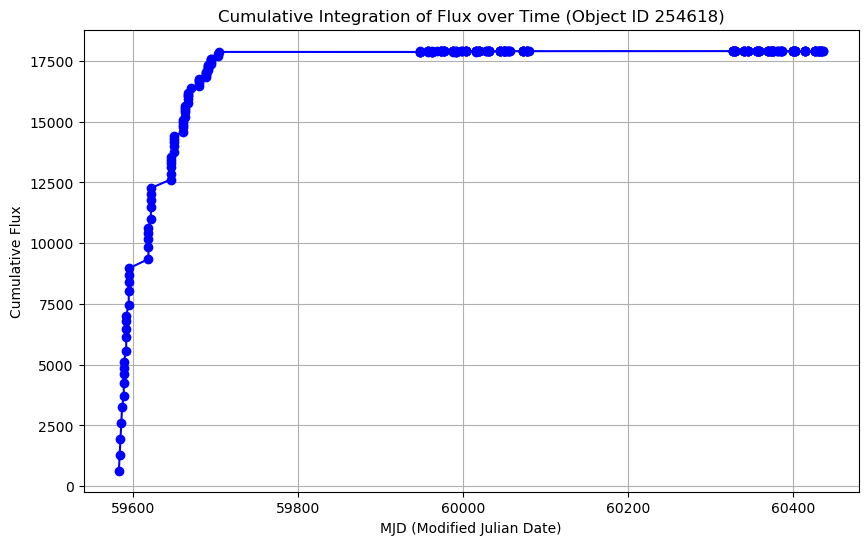

In [35]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_254618 = data[data['object_id'] == 254618]
data_254618 = data_254618.sort_values(by='mjd')

data_254618['cumulative_flux'] = data_254618['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_254618['mjd'], data_254618['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 254618)')
plt.grid()
plt.show()

Max smoothed slope: 44175.9177


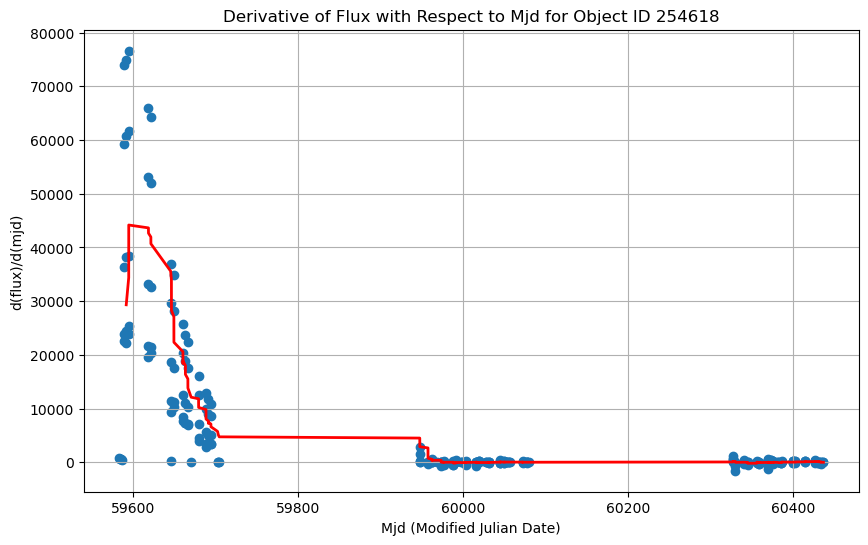

In [95]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_254618 = data[data['object_id'] == 254618]
data_254618 = data_254618.sort_values(by='mjd')

data_254618['cumulative_flux'] = data_254618['flux'].cumsum()
data_254618['flux_derivative'] = np.gradient(data_254618['cumulative_flux'], data_254618['mjd'])

data_254618.set_index('mjd', inplace=True)

smoothing = data_254618['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_254618.index, data_254618['flux_derivative'], label='Derivative of Flux for object_id 254618')
plt.plot(data_254618.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 254618')
plt.grid()
plt.show()

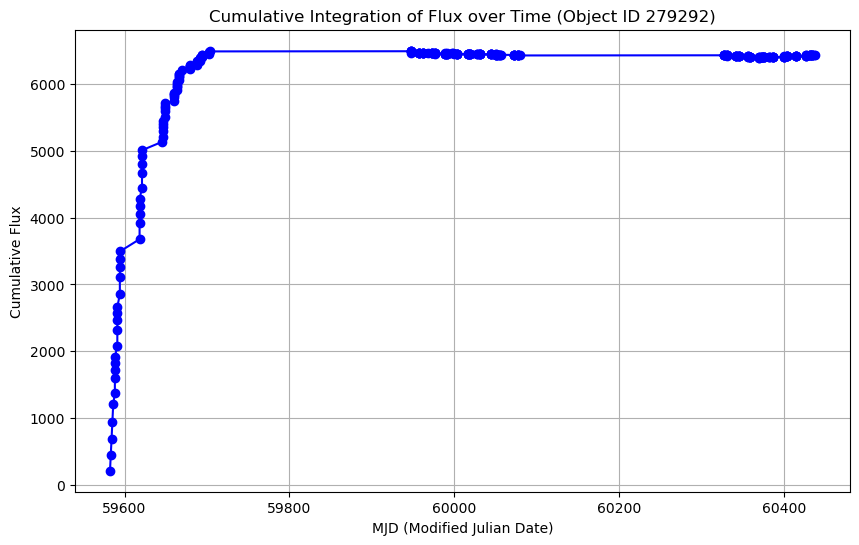

In [37]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_279292 = data[data['object_id'] == 279292]
data_279292 = data_279292.sort_values(by='mjd')

data_279292['cumulative_flux'] = data_279292['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_279292['mjd'], data_279292['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 279292)')
plt.grid()
plt.show()

Max smoothed slope: 18489.0033


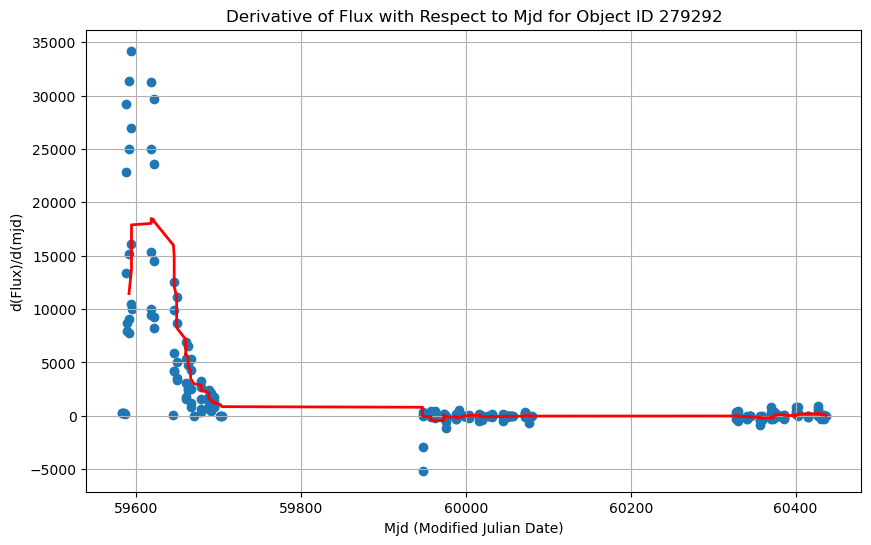

In [103]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_279292 = data[data['object_id'] == 279292]
data_279292 = data_279292.sort_values(by='mjd')

data_279292['cumulative_flux'] = data_279292['flux'].cumsum()
data_279292['flux_derivative'] = np.gradient(data_279292['cumulative_flux'], data_279292['mjd'])

data_279292.set_index('mjd', inplace=True)

smoothing = data_279292['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_279292.index, data_279292['flux_derivative'], label='Derivative of Flux for object_id 279292')
plt.plot(data_279292.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(Flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 279292')
plt.grid()
plt.show()

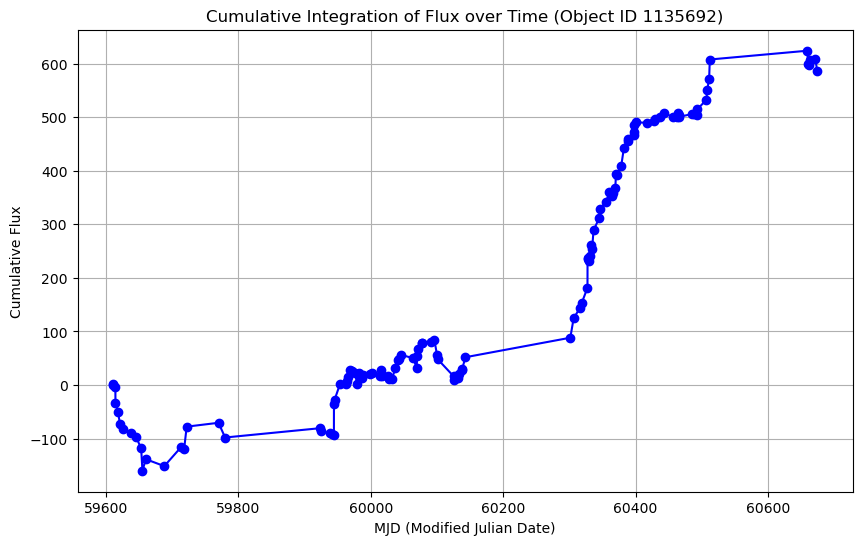

In [39]:
data = pd.read_csv("plasticc_train_lightcurves.csv.gz")
data_1135692 = data[data['object_id'] == 1135692]
data_1135692 = data_1135692.sort_values(by='mjd')

data_1135692['cumulative_flux'] = data_1135692['flux'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data_1135692['mjd'], data_1135692['cumulative_flux'], marker='o', linestyle='-', color='b', label='Cumulative Flux')
plt.xlabel('MJD (Modified Julian Date)')
plt.ylabel('Cumulative Flux')
plt.title('Cumulative Integration of Flux over Time (Object ID 1135692)')
plt.grid()
plt.show()

Max smoothed slope: 127.4873


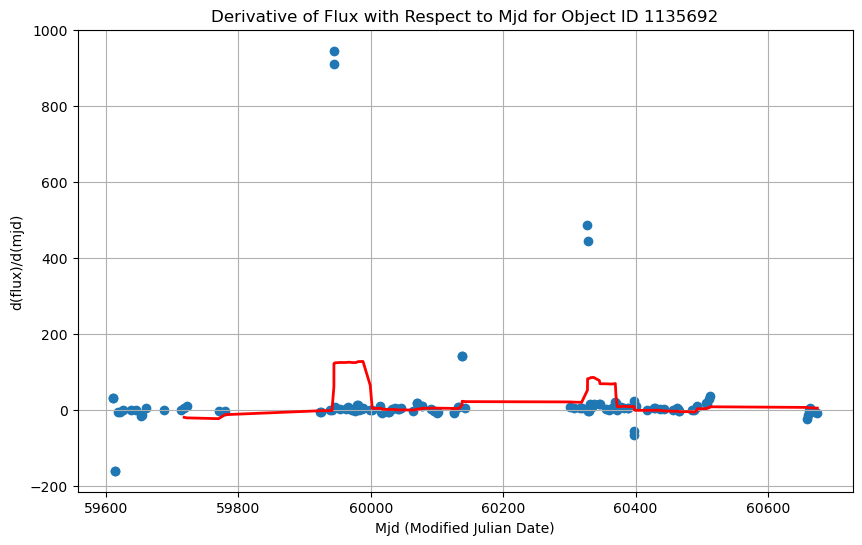

In [99]:
data = pd.read_csv('plasticc_train_lightcurves.csv.gz')
data_1135692 = data[data['object_id'] == 1135692]
data_1135692 = data_1135692.sort_values(by='mjd')

data_1135692['cumulative_flux'] = data_1135692['flux'].cumsum()
data_1135692['flux_derivative'] = np.gradient(data_1135692['cumulative_flux'], data_1135692['mjd'])

data_1135692.set_index('mjd', inplace=True)

smoothing = data_1135692['flux_derivative'].rolling(window=15).mean()
max_smoothed = smoothing.max()

print(f"Max smoothed slope: {max_smoothed:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(data_1135692.index, data_1135692['flux_derivative'], label='Derivative of Flux for object_id 1135692')
plt.plot(data_1135692.index, smoothing, linewidth=2, color='red')
plt.xlabel('Mjd (Modified Julian Date)')
plt.ylabel('d(flux)/d(mjd)')
plt.title('Derivative of Flux with Respect to Mjd for Object ID 1135692')
plt.grid()
plt.show()